In [1]:
!pip install xgboost shap lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=e7f2701eea7368c759d13e15db5a87febd196885cc6bf2fa9d53c4e837d06a7f
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.inspection import permutation_importance
import xgboost as xgb
import shap
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt

In [3]:
# Load preprocessed data
data = pd.read_csv('preprocessed_data.csv')
X = data.drop('SeriousDlqin2yrs', axis=1)
y = data['SeriousDlqin2yrs']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Initialize and train Decision Tree with Bagging
model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200]
}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:37:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200]},
             scoring='roc_auc')

In [5]:
# Best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.97      9336
           1       0.56      0.16      0.25       664

    accuracy                           0.94     10000
   macro avg       0.75      0.58      0.61     10000
weighted avg       0.92      0.94      0.92     10000

ROC AUC Score: 0.8559368418403691
Confusion Matrix:
 [[9252   84]
 [ 556  108]]


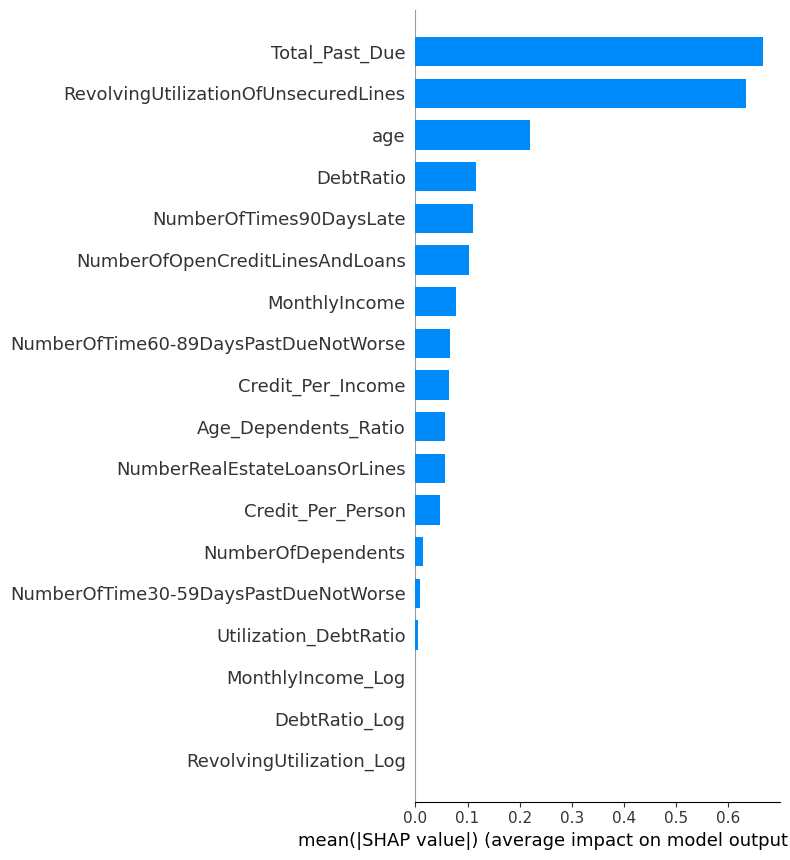

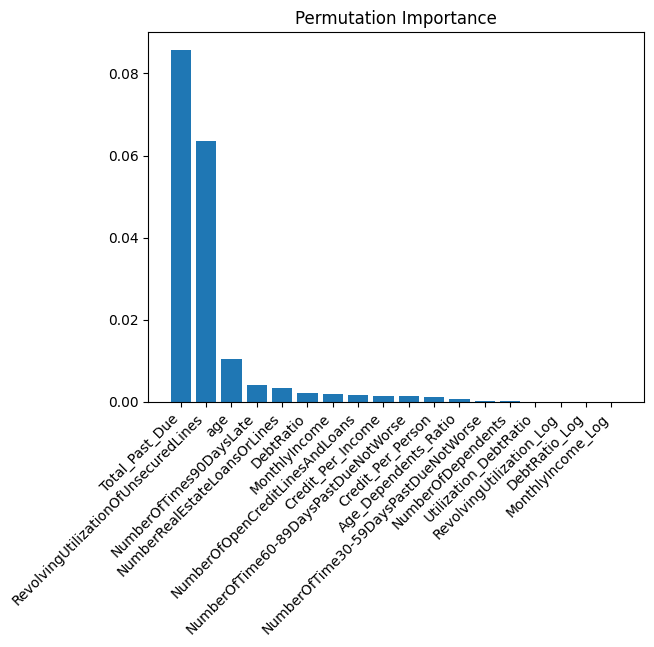

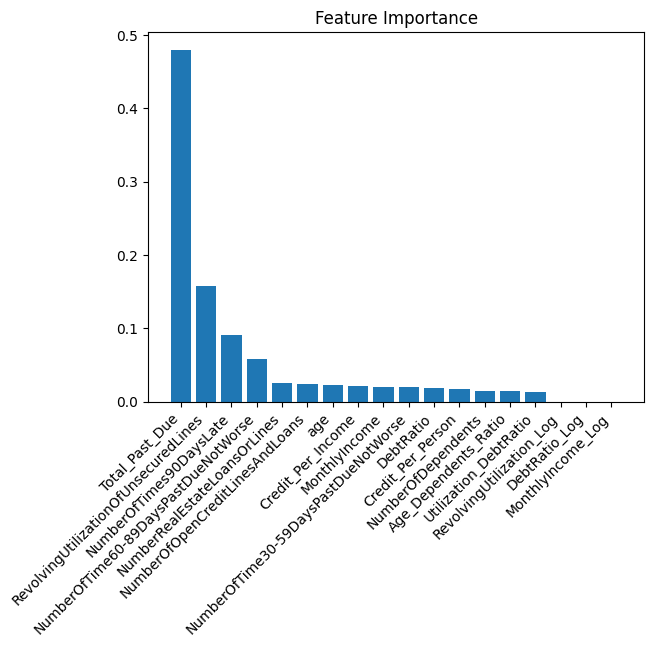

In [10]:
# Explainability Techniques
# 1. SHAP
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

# 2. LIME
lime_explainer = LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    class_names=['Non-Default', 'Default'],
    mode='classification'
)
lime_exp = lime_explainer.explain_instance(X_test.iloc[0].values, best_model.predict_proba)
lime_exp.show_in_notebook()


# 3. Permutation Importance
perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42, scoring='roc_auc')
perm_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
})
perm_df = perm_df.sort_values('Importance', ascending=False)
plt.bar(perm_df['Feature'], perm_df['Importance'])
plt.xticks(rotation=45, ha='right')
plt.title('Permutation Importance')
plt.show()

# 4. Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_model.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
plt.bar(feature_importance['Feature'], feature_importance['Importance'])
plt.xticks(rotation=45, ha='right')
plt.title('Feature Importance')
plt.show()